<a href="https://colab.research.google.com/github/sahil-bhatia-iitbhu/deep_understanding_of_deep_learning/blob/main/13_Convolution_and_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Convolution Concepts

1. Primarily used to extract features in a breakdown structure, means each convolution focus on some form of feature extraction which are later combined in stages to learn patterns by combining simpler features into complex features.
2. Understand it as if we align different neurons to focus on different parts of the data to understand the structure section-wise, yet those sections could be present anywhere in real data.
3. Kernels are mini-cameras that move across data step-by-step to capture features section-wise and send to neurons to learn. Should be ideally odd-numbered in size to be able to centered properly.

In DL, kernels start as random and are learned through gradient descent. After learning, kernels are the same for all images.

This means, the model itself decides its mini-cameras to capture features relevant to use case.

### 2D Convolution Implementation

In [9]:
# import libraries
import numpy as np

# convolution
from scipy.signal import convolve2d

# to read an image from a url
import imageio.v2 as imageio

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

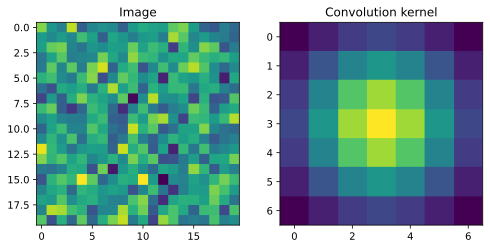

In [2]:
# image
imgN = 20
image = np.random.randn(imgN,imgN)

# convolution kernel
kernelN = 7
Y,X = np.meshgrid(np.linspace(-3,3,kernelN),np.linspace(-3,3,kernelN))
kernel = np.exp( -(X**2+Y**2)/7 )


# let's see what they look like
fig,ax = plt.subplots(1,2,figsize=(8,6))
ax[0].imshow(image)
ax[0].set_title('Image')

ax[1].imshow(kernel)
ax[1].set_title('Convolution kernel')

plt.show()

In [3]:
# now for the convolution
convoutput = np.zeros((imgN,imgN))
halfKr = kernelN//2

for rowi in range(halfKr,imgN-halfKr):
  for coli in range(halfKr,imgN-halfKr):

    # cut out a piece of the image
    pieceOfImg = image[rowi-halfKr:rowi+halfKr+1,:]      # get the rows
    pieceOfImg = pieceOfImg[:,coli-halfKr:coli+halfKr+1] # extract the columns

    # dot product: element-wise multiply and sum (and flip the kernel for "real convolution")
    dotprod = np.sum( pieceOfImg*kernel[::-1,::-1] )

    # store the result for this pixel
    convoutput[rowi,coli] = dotprod

In [4]:
# using scipy
convoutput2 = convolve2d(image,kernel,mode='valid')

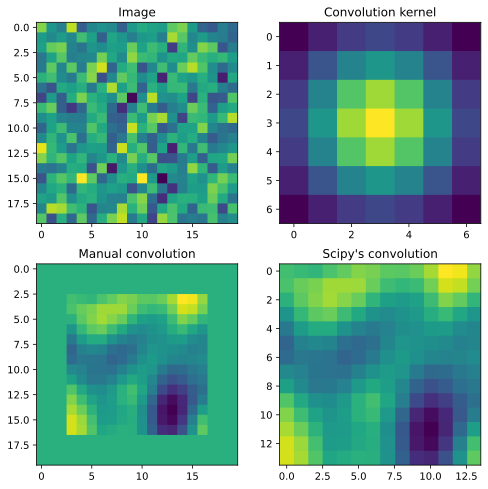

In [5]:
fig,ax = plt.subplots(2,2,figsize=(8,8))

ax[0,0].imshow(image)
ax[0,0].set_title('Image')

ax[0,1].imshow(kernel)
ax[0,1].set_title('Convolution kernel')

ax[1,0].imshow(convoutput)
ax[1,0].set_title('Manual convolution')

ax[1,1].imshow(convoutput2)
ax[1,1].set_title("Scipy's convolution")

plt.show()

(1080, 1920, 3)
(1080, 1920)


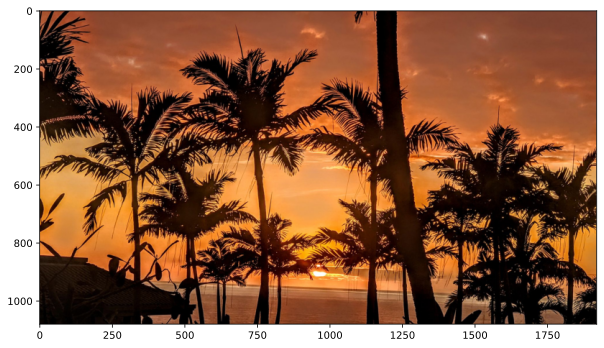

In [13]:
# read a pic from the web
bathtub = imageio.imread('https://www.industrialempathy.com/img/remote/ZiClJf-1920w.jpg')

# check the size
print(bathtub.shape)

# let's see what the famous Bathtub Museum looks like
fig = plt.figure(figsize=(10,6))
plt.imshow(bathtub);

# transform image to 2D for convenience (not necessary for convolution!)
bathtub = np.mean(bathtub,axis=2)
bathtub = bathtub/np.max(bathtub)

# check the size again
print(bathtub.shape)

In [14]:
# hand-craft two convolution kernels

# vertical kernel
VK = np.array([ [1,0,-1],
                [1,0,-1],
                [1,0,-1] ])

# horizontal kernel
HK = np.array([ [ 1, 1, 1],
                [ 0, 0, 0],
                [-1,-1,-1] ])

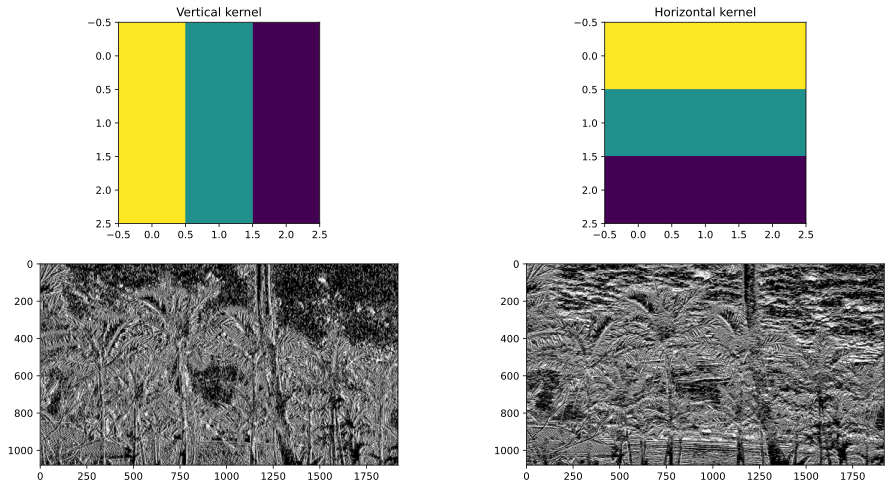

In [15]:
fig,ax = plt.subplots(2,2,figsize=(16,8))

ax[0,0].imshow(VK)
ax[0,0].set_title('Vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('Horizontal kernel')


# run convolution and show the result
convres = convolve2d(bathtub,VK,mode='same')
ax[1,0].imshow(convres,cmap='gray',vmin=0,vmax=.01)

convres = convolve2d(bathtub,HK,mode='same')
ax[1,1].imshow(convres,cmap='gray',vmin=0,vmax=.01)

plt.show()

**Now in PyTorch**

In [16]:
# first, translate everything into a tensor
import torch
import torch.nn.functional as F

VK_t = torch.tensor(VK).view(1,1,3,3).double()
HK_t = torch.tensor(HK).view(1,1,3,3).double()
bathtub_t = torch.tensor(bathtub).view(1,1,bathtub.shape[0],bathtub.shape[1])

print(VK_t.shape)
print(bathtub_t.shape)

torch.Size([1, 1, 3, 3])
torch.Size([1, 1, 1080, 1920])


In [17]:
C = F.conv2d(bathtub_t,VK_t)
print(C.shape)

torch.Size([1, 1, 1078, 1918])


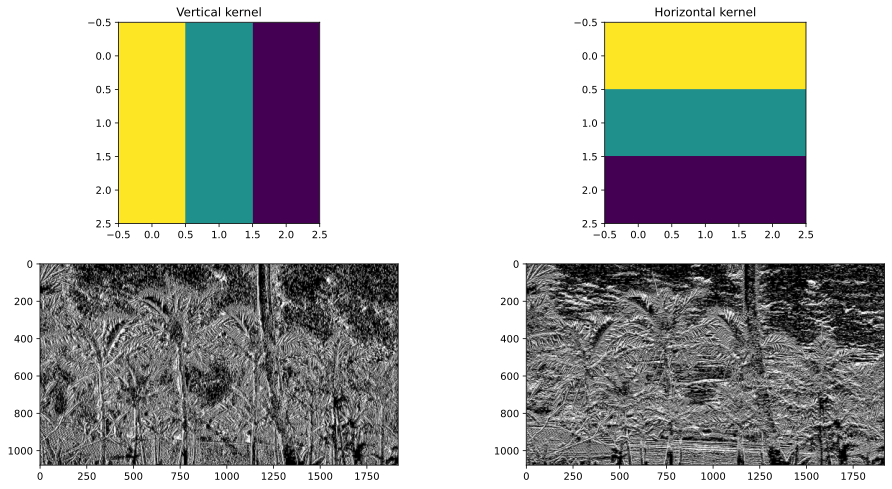

In [18]:
fig,ax = plt.subplots(2,2,figsize=(16,8))

ax[0,0].imshow(VK)
ax[0,0].set_title('Vertical kernel')

ax[0,1].imshow(HK)
ax[0,1].set_title('Horizontal kernel')


# run convolution and show the result
convres = F.conv2d(bathtub_t,VK_t)
img = torch.squeeze(convres.detach())
ax[1,0].imshow(img,cmap='gray',vmin=0,vmax=.01)

convres = F.conv2d(bathtub_t,HK_t)
img = torch.squeeze(convres.detach())
ax[1,1].imshow(img,cmap='gray',vmin=0,vmax=.01)

plt.show()

### Stride and Padding

1. Padding helps to keep the convolution the same size as input image. It is executed by adding zeros around the image (linear padding), or tieing the ends togethor (circular padding)
2. Stride is used to decrease the size of the result of convolution, means downsampling, and hence reduces the count of parameters in CNN.

### Conv2 Class in Pytorch

In [19]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [20]:
# create a conv2d class instance with parameters

# parameters
inChans  = 3 # RGB
outChans = 15
krnSize  = 5 # should be an odd number
stride   = 1
padding  = 0

# create the instance (cf nn.Linear)
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# let's have a look at it
print(c)
print(' ')

# check out its weight tensor; what are the dimensions?
print( 'Size of weights: ' + str(c.weight.shape) )
print( 'Size of bias: ' + str(c.bias.shape) )

Conv2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
 
Size of weights: torch.Size([15, 3, 5, 5])
Size of bias: torch.Size([15])


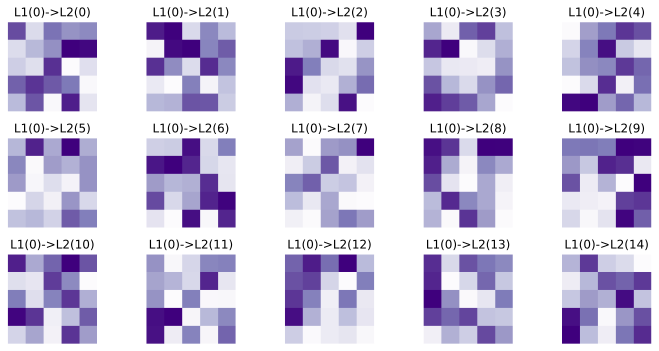

In [21]:
# What do these kernels look like?

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(c.weight[i,0,:,:]).detach(),cmap='Purples')
  ax.set_title('L1(0)->L2(%s)'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)


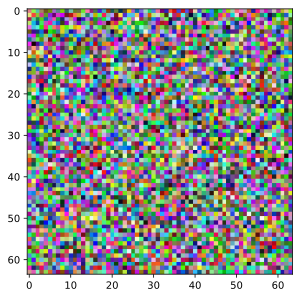

In [22]:
# size of the image (N, RGB, height, width)
imsize = (1,3,64,64)

img = torch.rand(imsize)

# pytorch wants channels first, but matplotlib wants channels last.
# therefore, tensors must be permuted to visualize
img2view = img.permute(2,3,1,0).numpy()
print(img.shape)
print(img2view.shape)

plt.imshow(np.squeeze(img2view));

In [23]:
# convolve the image with the filter bank (set of 'outChans' kernels)
convRes = c(img)

print(img.shape)
print(convRes.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 15, 60, 60])


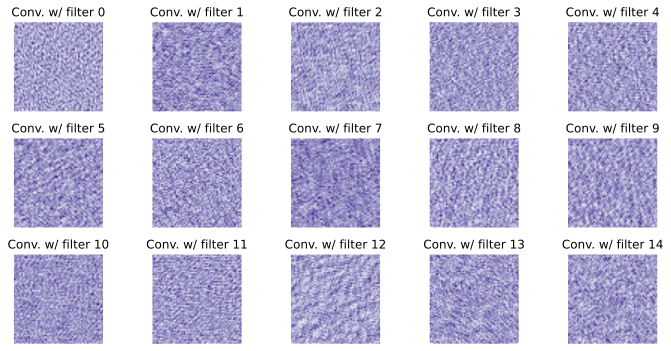

In [24]:
# What do the convolved images look like? (Hint: think of the bathtub picture.)

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):

  # extract this "layer" of the convolution result
  I = torch.squeeze(convRes[0,i,:,:]).detach()

  # and visualize it
  ax.imshow(I,cmap='Purples')
  ax.set_title('Conv. w/ filter %s'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

Choose the parameters Code Challenge

In [25]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

Convolve an image of size 1x256x256 to produce a 1x252x84 result

In [27]:
# parameters
inChans  = 1 # RGB
imsize   = [256,256]
outChans = 1
krnSize  = 7 # should be an odd number
stride   = (1,3)
padding  = 1

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [  1 252  84]
Empirical size: [252, 84]


**Real Problems:**

1) Convolve an image of size 3x64x64 to produce a 10x28x28 result

In [36]:
# parameters
inChans  = 3
imsize   = [64,64]
outChans = 10
krnSize  = 9
stride   = (2,2)
padding  = 0

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [10 28 28]
Empirical size: [10, 28, 28]


2) Convolve an image of size 3x196x96 to produce a 5x66x49 result

In [37]:
# parameters
inChans  = 3
imsize   = [196,96]
outChans = 5
krnSize  = 2
stride   = (3,2)
padding  = 1

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Expected size: [ 5 66 49]
Empirical size: [5, 66, 49]


3) Convolve an image of size 1x32x32 to produce a 6x28x28 result

In [ ]:
# note: these dimensions are the input -> first hidden layer of the famous LeNet-5

# parameters
inChans  =
imsize   =
outChans =
krnSize  =
stride   =
padding  =

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

4) Convolve an image of size 3x227x227 to produce a 96x55x55 result

In [ ]:

# note: these dimensions are the input -> first hidden layer of the famous AlexNet

# parameters
inChans  =
imsize   =
outChans =
krnSize  =
stride   =
padding  =

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

5) Convolve an image of size 3x224x224 to produce a 64x224x224 result

In [ ]:
# note: these dimensions are the input -> first hidden layer of the famous VGG-16

# parameters
inChans  =
imsize   =
outChans =
krnSize  =
stride   =
padding  =

# create the instance
c = nn.Conv2d(inChans,outChans,krnSize,stride,padding)

# create an image
img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
resimg = c(img)
empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
expectSize = np.array([outChans,0,0],dtype=int)
expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
print(f'Expected size: {expectSize}')
print(f'Empirical size: {list(empSize)}')

Answers

In [ ]:
# 1)
inChans  = 3
imsize   = [64,64]
outChans = 10
krnSize  = 9
stride   = (2,2)
padding  = 0

# 2)
inChans  = 3
imsize   = [196,96]
outChans = 5
krnSize  = 5
stride   = (3,2)
padding  = 3

# 3)
inChans  = 1
imsize   = [32,32]
outChans = 6
krnSize  = 5
stride   = (1,1)
padding  = 0

# 4)
inChans  = 3
imsize   = [227,227]
outChans = 96
krnSize  = 11
stride   = (4,4)
padding  = 1

# 5)
inChans  = 3
imsize   = [224,224]
outChans = 64
krnSize  = 3
stride   = (1,1)
padding  = 1

### Transpose Convolution

1. It means to scalar-multiply the kernel with each pixel of the image.
2. It is used in autoencoders and super-resolution in CNNs.
3. Its output is increased resolution of image.

In [38]:
# import libraries
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

In [39]:
# create a ConvTranspose2d class instance with parameters

# parameters
inChans  = 3 # RGB
outChans = 15
krnSize  = 5 # should be an odd number
stride   = 1
padding  = 0

# create the instance
c = nn.ConvTranspose2d(inChans,outChans,krnSize,stride,padding)

# let's have a look at it
print(c)
print(' ')

# check out its weight tensor; what are the dimensions?
print( 'Size of weights: ' + str(c.weight.shape) )
print( 'Size of bias: ' + str(c.bias.shape) )

# tip: Compare the sizes of these weights with those of "forward" convolution (DUDL_convolution_conv2.ipynb)

ConvTranspose2d(3, 15, kernel_size=(5, 5), stride=(1, 1))
 
Size of weights: torch.Size([3, 15, 5, 5])
Size of bias: torch.Size([15])


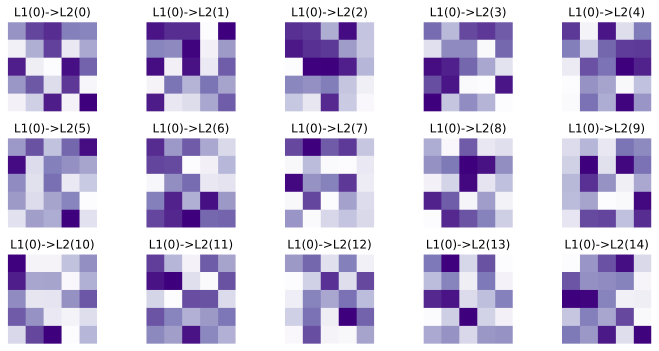

In [40]:
# What do these kernels look like?

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):
  ax.imshow(torch.squeeze(c.weight[0,i,:,:]).detach(),cmap='Purples')
  ax.set_title('L1(0)->L2(%s)'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

torch.Size([1, 3, 64, 64])
(64, 64, 3, 1)


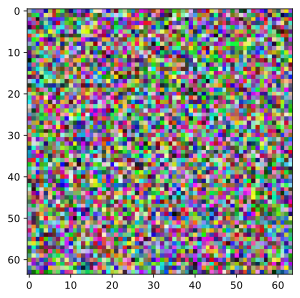

In [41]:
# size of the image (N, RGB, width, height)
imsize = (1,3,64,64)

img = torch.rand(imsize)

# pytorch wants channels first, but matplotlib wants channels last.
# therefore, tensors must be permuted to visualize
img2view = img.permute(2,3,1,0).numpy()
print(img.shape)
print(img2view.shape)

plt.imshow(np.squeeze(img2view));

In [42]:

# convolve the image with the filter bank (set of 'outChans' kernels)
convRes = c(img)

print(img.shape)
print(convRes.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 15, 68, 68])


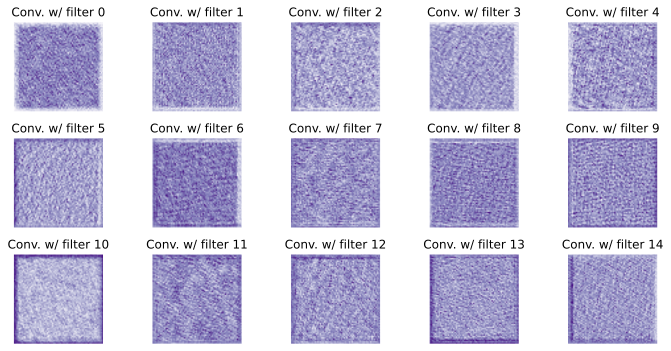

In [43]:
# What do the convolved images look like? (Hint: think of the bathtub picture.)

fig,axs = plt.subplots(3,5,figsize=(10,5))

for i,ax in enumerate(axs.flatten()):

  # extract this "layer" of the convolution result
  I = torch.squeeze(convRes[0,i,:,:]).detach()

  # and visualize it
  ax.imshow(I,cmap='Purples')
  ax.set_title('Conv. w/ filter %s'%i)
  ax.axis('off')

plt.tight_layout()
plt.show()

### Pooling: Mean and Max

1. Both are used for downsampling (reducing parameters) but outputs are different for both Mean and Max
2. Additionally, it helps increase the "receptive area" of the channels
3. Mean vs Max:
- Mean - Smooths images (its a low pass filter). Useful for noisy data and to reduce the impact of outliers on learning.
- Max - Highlights Sharp features. Useful for sparse data and increasing contrast. Min pooling is same as Max pooling.
4. Receptive Fields:
- It is the section-size of image captured by one unit in a given layer.
- ANNs have one-to-one mapping between pixel and units, which makes model non-robust to translation, resizing, rotation etc.
- In CNNs, as we go deep, the receptive field increases for units.
- Pooling allows for more visibility of sections of images.

In [44]:
# import libraries
import torch
import torch.nn as nn

In [45]:
# create a pool class instance with parameters

# parameters
poolSize = 3
stride   = 3

# create the instance
p2 = nn.MaxPool2d(poolSize,stride=3)
p3 = nn.MaxPool3d(poolSize,stride=3)

# let's have a look at them
print(p2)
print(p3)

MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)


In [46]:
# Create image and apply maxpooling

# create a 2D and a 3D image
img2 = torch.randn(1,1,30,30)
img3 = torch.randn(1,3,30,30)


# all combinations of image and maxpool dimensionality
img2Pool2 = p2(img2)
print(f'2D image, 2D maxpool: {img2Pool2.shape}\n' )

# img2Pool3 = p3(img2)
# print(f'2D image, 3D maxpool: {img2Pool3.shape}\n' )

img3Pool2 = p2(img3)
print(f'3D image, 2D maxpool: {img3Pool2.shape}\n' )

img3Pool3 = p3(img3)
print(f'3D image, 3D maxpool: {img3Pool3.shape}\n' )

2D image, 2D maxpool: torch.Size([1, 1, 10, 10])

3D image, 2D maxpool: torch.Size([1, 3, 10, 10])

3D image, 3D maxpool: torch.Size([1, 1, 10, 10])



In [47]:
### Lets create a little CNN ###

littlenet = nn.Sequential(

    ## the conv-pool block
    nn.Conv2d(3,10,5,3,2), # convolution layer
    nn.ReLU(),             # activation function
    nn.AvgPool3d(3,3),     # average-pool

    ## the FFN block
    nn.Flatten(),          # vectorize to get from image to linear
    nn.Linear(588,1),      # FC linear layer
    nn.Sigmoid()           # output activation
  )


In [48]:
# test with a bit of data
img = torch.rand(1,3,128,128)
littlenet(img)

tensor([[0.5405]], grad_fn=<SigmoidBackward0>)

### Pooling vs Stride

Pooling:
- Computationally Fast
- No Parameters
- Kernel spans a smaller area (Lower receptive fields)
- Highly Stable

Stride:
- Computationally Slower
- Learned Parameters
- Kernel spans a larger area (Larger receptive fields)
- Can be unstable in complex architectures

Historically Pooling has been preffered, hence hold priority in industry

### Transform Images

1. To resize the image
2. To convert to grayscale
3. For data augmentation, chnaging the raw pixels without changing the image information.

In [49]:
# import libraries
import numpy as np
import torch

# NEW!
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [50]:
# download the CIFAR10 dataset
cdata = torchvision.datasets.CIFAR10(root='cifar10', download=True)

print(cdata)


# check out the shape of the dataset
print( cdata.data.shape )

# the unique categories
print( cdata.classes )

# .targets is a list of targets converted to ints
print( len(cdata.targets) )

100%|██████████| 170M/170M [00:05<00:00, 29.1MB/s]


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: cifar10
    Split: Train
(50000, 32, 32, 3)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
50000


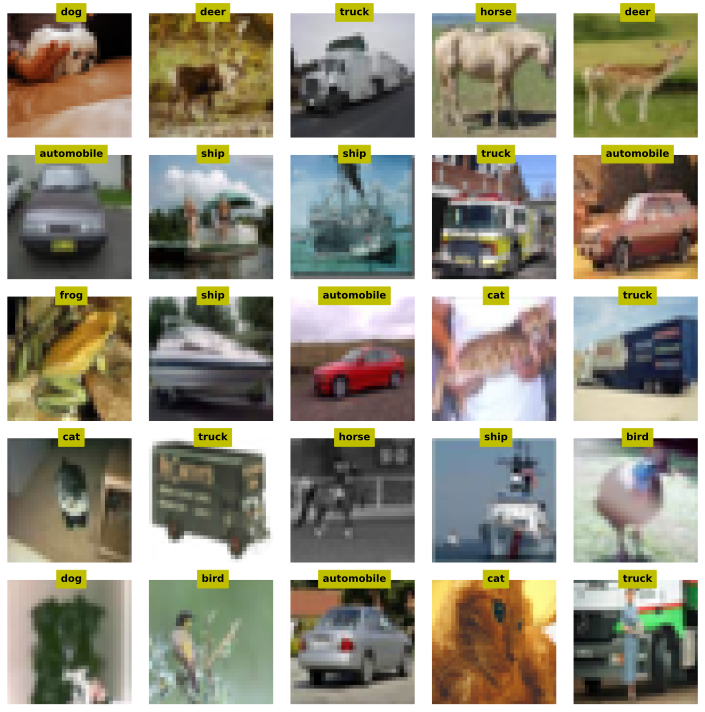

In [51]:
# inspect a few random images

fig,axs = plt.subplots(5,5,figsize=(10,10))

for ax in axs.flatten():

  # select a random picture
  randidx = np.random.choice(len(cdata.targets))

  # extract that image
  pic = cdata.data[randidx,:,:,:]
  # and its label
  label = cdata.classes[cdata.targets[randidx]]

  # and show!
  ax.imshow(pic)
  ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

In [52]:
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(32*4),
                 T.Grayscale(num_output_channels=1)  ])

# include the transform in the dataset
cdata.transform = Ts

# you can also apply the transforms immediately when loading in the data
# cdata = torchvision.datasets.CIFAR10(root='cifar10', download=True, transform=Ts)


# Important! Adding a transform doesn't change the image data:
print(cdata.data[123,:,:,:].shape)

(32, 32, 3)


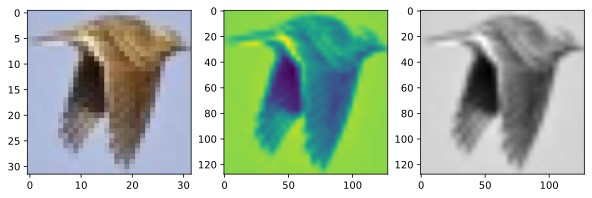

In [53]:
# apply the transform

# option 1a: apply the transform "externally" to an image
img1 = Ts( cdata.data[123,:,:,:] )

# option 1b: use the embedded transform
img2 = cdata.transform( cdata.data[123,:,:,:] )

# let's see what we've done!
fig,ax = plt.subplots(1,3,figsize=(10,3))
ax[0].imshow(cdata.data[123,:,:,:])
ax[1].imshow(torch.squeeze(img1))
ax[2].imshow(torch.squeeze(img2),cmap='gray')

plt.show()

In [54]:
# Note about ToTensor() and normalization:
??T.ToTensor()

Object `T.ToTensor()` not found.
